In [46]:
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.dates as mdates
import datetime as dt

from statsmodels.graphics.tsaplots import acf, pacf
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller



# DOGE

## Step #1: Read Data

In [47]:
# Read data
df = pd.read_csv('../../../Dataset/DOGE-USD.csv', parse_dates=['Date'])
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,2018-03-01,0.006042,0.006320,0.005945,0.006215,0.006215,15518400
1,2018-03-02,0.006174,0.006232,0.005447,0.005482,0.005482,22498100
2,2018-03-03,0.005494,0.005756,0.005181,0.005301,0.005301,21545000
3,2018-03-04,0.005234,0.005502,0.005164,0.005502,0.005502,12133500
4,2018-03-05,0.005462,0.005535,0.005157,0.005218,0.005218,13627700
...,...,...,...,...,...,...,...
2280,2024-05-28,0.169090,0.169330,0.161796,0.164962,0.164962,1410223091
2281,2024-05-29,0.164964,0.170269,0.162220,0.163695,0.163695,1525668595
2282,2024-05-30,0.163696,0.165407,0.156595,0.159544,0.159544,1452218159
2283,2024-05-31,0.159539,0.162226,0.154907,0.159136,0.159136,945969518


## Step #2: Explore the Data

In [48]:
# Dataset Description
df = df.set_index('Date')
print(f"Dataset Shape: {df.shape}")
print(f"Dataset Info: {df.info()}")
print(f"Dataset Describe: {df.describe()}")

Dataset Shape: (2285, 6)
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2285 entries, 2018-03-01 to 2024-06-01
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       2285 non-null   float64
 1   High       2285 non-null   float64
 2   Low        2285 non-null   float64
 3   Close      2285 non-null   float64
 4   Adj Close  2285 non-null   float64
 5   Volume     2285 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 125.0 KB
Dataset Info: None
Dataset Describe:               Open         High          Low        Close    Adj Close  \
count  2285.000000  2285.000000  2285.000000  2285.000000  2285.000000   
mean      0.070440     0.074000     0.067026     0.070516     0.070516   
std       0.090590     0.097472     0.083922     0.090653     0.090653   
min       0.001540     0.001612     0.001247     0.001537     0.001537   
25%       0.002757     0.002824     0.002663     0.002756     0.002756  

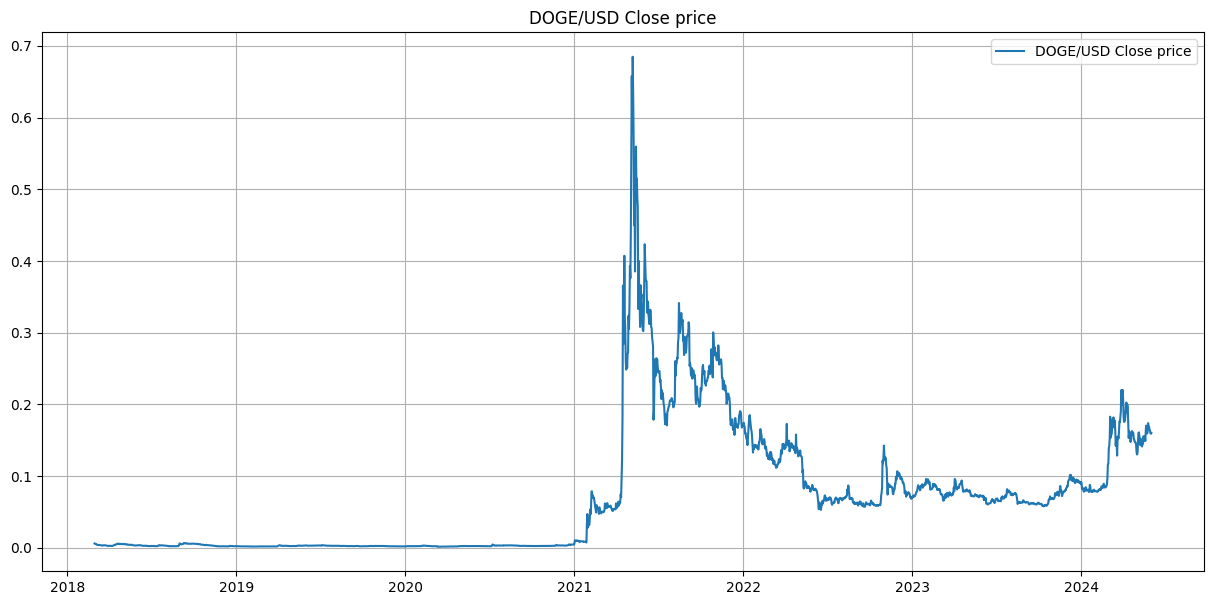

In [49]:
# Plotting data
plt.figure(figsize=(15, 7))
plt.plot(df.Close, label='DOGE/USD Close price')
plt.title('DOGE/USD Close price')
plt.grid()
plt.legend()
plt.show()


## Step #3: Feature Engineering

In [50]:
# Feature Engineering
def createFeatures(df):
    df = pd.DataFrame(df)

    
    # df['Close_Diff'] = df['Adj Close'].diff()
        
    # Moving averages - different periods
    df['MA200'] = df['Close'].rolling(window=200).mean() 
    df['MA100'] = df['Close'].rolling(window=100).mean() 
    df['MA50'] = df['Close'].rolling(window=50).mean() 
    df['MA26'] = df['Close'].rolling(window=26).mean() 
    df['MA20'] = df['Close'].rolling(window=20).mean() 
    df['MA12'] = df['Close'].rolling(window=12).mean() 
    
    # SMA Differences - different periods
    df['DIFF-MA200-MA50'] = df['MA200'] - df['MA50']
    df['DIFF-MA200-MA100'] = df['MA200'] - df['MA100']
    df['DIFF-MA200-CLOSE'] = df['MA200'] - df['Close']
    df['DIFF-MA100-CLOSE'] = df['MA100'] - df['Close']
    df['DIFF-MA50-CLOSE'] = df['MA50'] - df['Close']
    
    # Moving Averages on high, lows, and std - different periods
    # df['MA200_low'] = df['Low'].rolling(window=200).min()
    # df['MA14_low'] = df['Low'].rolling(window=14).min()
    # df['MA200_high'] = df['High'].rolling(window=200).max()
    # df['MA14_high'] = df['High'].rolling(window=14).max()
    df['MA20dSTD'] = df['Close'].rolling(window=20).std() 
    
    # Exponential Moving Averages (EMAS) - different periods
    df['EMA12'] = df['Close'].ewm(span=12, adjust=False).mean()
    df['EMA20'] = df['Close'].ewm(span=20, adjust=False).mean()
    df['EMA26'] = df['Close'].ewm(span=26, adjust=False).mean()
    df['EMA100'] = df['Close'].ewm(span=100, adjust=False).mean()
    df['EMA200'] = df['Close'].ewm(span=200, adjust=False).mean()

    # Shifts (one day before and two days before)
    df['close_shift-1'] = df.shift(-1)['Close']
    df['close_shift-2'] = df.shift(-2)['Close']

    # Bollinger Bands
    df['Bollinger_Upper'] = df['MA20'] + (df['MA20dSTD'] * 2)
    df['Bollinger_Lower'] = df['MA20'] - (df['MA20dSTD'] * 2)
    df['Bollinger_Middle'] = df['MA20'] 
    
    # Relative Strength Index (RSI)
    # df['K-ratio'] = 100*((df['Close'] - df['MA14_low']) / (df['MA14_high'] - df['MA14_low']) )
    # Relative Strength Index (RSI) not using the K-ratio
    # df['RSI'] = df['K-ratio'].rolling(window=3).mean() 

    # Moving Average Convergence/Divergence (MACD)
    df['MACD'] = df['EMA12'] - df['EMA26']
    
    # Replace nas 
    nareplace = df.at[df.index.max(), 'Close']    
    df.fillna((nareplace), inplace=True)

    return df

               Close  MACD_shift-1  Bollinger_Upper_shift-1  Bollinger_Lower_shift-1  MA26_shift-1  EMA20_shift-1
Date                                                                                                             
2024-05-28  0.164962      0.004158                 0.176558                 0.134979      0.154679       0.159572
2024-05-29  0.163695      0.004031                 0.177157                 0.136547      0.155942       0.160086
2024-05-30  0.159544      0.003784                 0.177827                 0.137035      0.156617       0.160429
2024-05-31  0.159136      0.003216                 0.177613                 0.138800      0.156594       0.160345
2024-06-01  0.160200      0.002702                 0.177041                 0.140993      0.156519       0.160230
               Close  MACD_shift-1  Bollinger_Upper_shift-1  Bollinger_Lower_shift-1  MA26_shift-1  EMA20_shift-1
Date                                                                                    

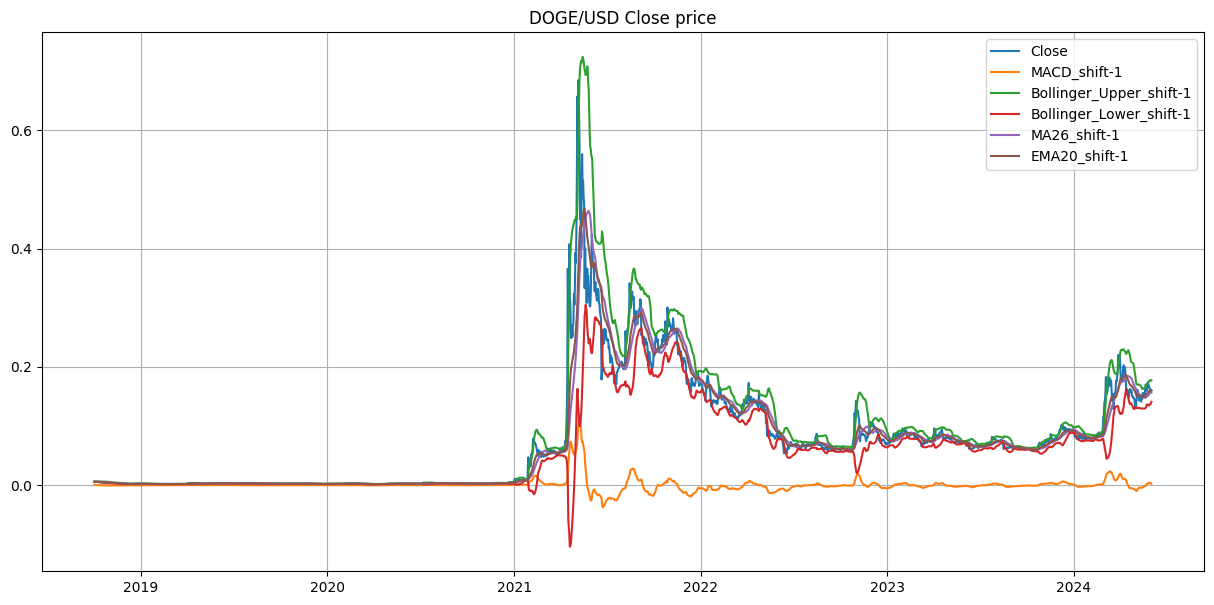

In [51]:
# List of considered Features
FEATURES = [
            # 'High',
            # 'Low',
            # 'Open',
            'Close',
            # 'Volume',
#             'Day',
#             'Month',
#             'Year',
            # 'Adj Close',
#              'close_shift-1',
#              'close_shift-2',
            'MACD',
            # 'RSI',
            # 'MA200',
#             'MA200_high',
#             'MA200_low',
            'Bollinger_Upper',
            'Bollinger_Lower',
            # 'MA100',            
#             'MA50',
            'MA26',
#             'MA14_low',
#             'MA14_high',
            # 'MA12',
            'EMA20',
            # 'EMA100',
#             'EMA200',
#               'DIFF-MA200-MA50',
#               'DIFF-MA200-MA100',
#             'DIFF-MA200-CLOSE',
#             'DIFF-MA100-CLOSE',
#             'DIFF-MA50-CLOSE',
            # 'MA20dSTD',
            # 'Close_Diff',
            # 'K-ratio'
           ]

# Create the dataset with features
df_features = createFeatures(df)

# Shift the timeframe by 10 month -> Start date is 2010-11-01
use_start_date = pd.to_datetime("2018-10-01")
df_features = df_features[df_features.index > use_start_date].copy()

# Filter the data to the list of FEATURES
df_filtered = df_features[FEATURES].copy()

df_original = df_filtered.copy()

# Create shifted features
for feature in FEATURES:
    if feature != 'Close':
        df_filtered[feature + '_shift-1'] = df_filtered[feature].shift(1)
        df_filtered = df_filtered.drop(feature, axis=1)

df_filtered = df_filtered.dropna()


print(df_filtered.tail().to_string())
print(df_filtered.head().to_string())
print(df_original.head().to_string())
print(df_original.tail().to_string())

# Create the lineplot
plt.figure(figsize=(15, 7))
plt.plot(df_filtered)
plt.title('DOGE/USD Close price')
plt.grid()
plt.legend(df_filtered.columns)
plt.show()


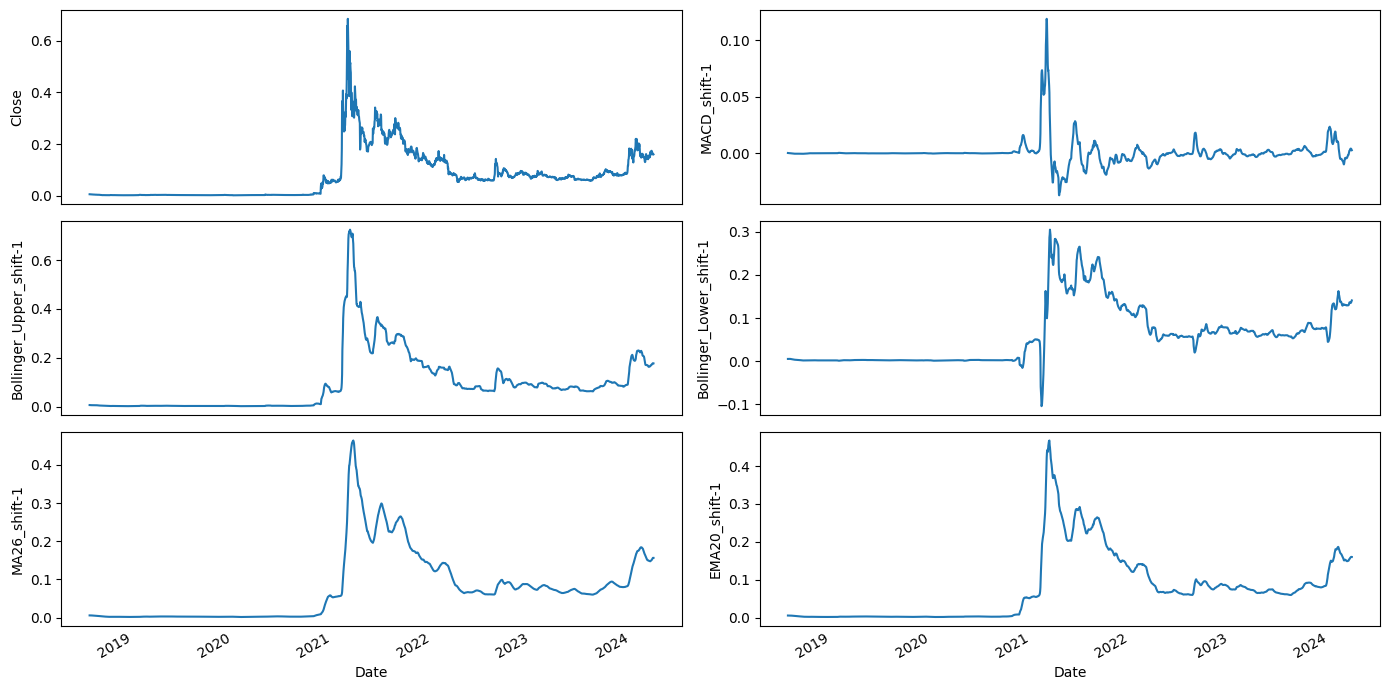

In [52]:
# Plot line charts
df_plot = df_filtered.copy()

ncols = 2
nrows = int(round(df_plot.shape[1] / ncols, 0))

fig, ax = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, figsize=(14, 7))
for i, ax in enumerate(fig.axes):
        sns.lineplot(data = df_plot.iloc[:, i], ax=ax)
        ax.tick_params(axis="x", rotation=30, labelsize=10, length=0)
        ax.xaxis.set_major_locator(mdates.AutoDateLocator())
fig.tight_layout()
plt.show()

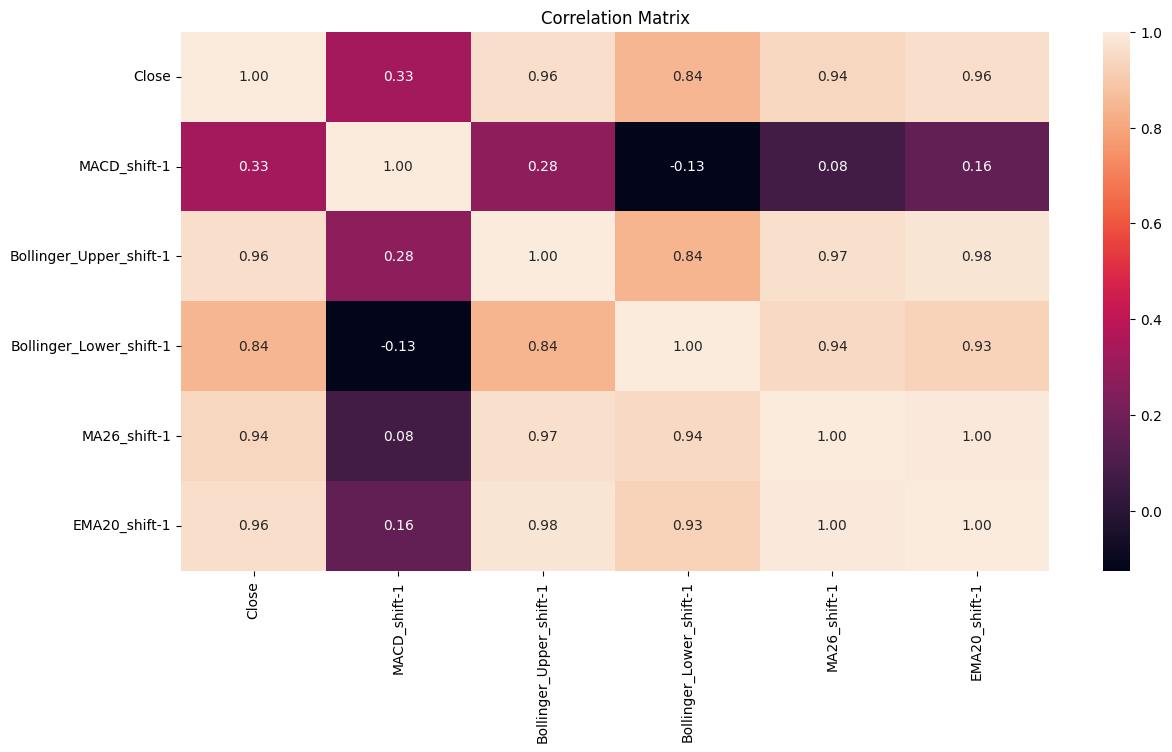

In [53]:
# Coorelation Matrix
plt.figure(figsize=(14, 7))
sns.heatmap(df_filtered.corr(), annot=True, fmt=".2f")
plt.title('Correlation Matrix')
plt.show()


In [54]:
# Granger causality test to check if the past values of the time series affect the current value of the time series
from statsmodels.tsa.stattools import grangercausalitytests
maxlag = 24
test = 'ssr_chi2test'

def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1], 4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

grangers_causation_matrix(df, variables = df.columns)



,Open_x,High_x,Low_x,Close_x,Adj Close_x,Volume_x
Open_y,1.0,0.0,0.0,0.0,0.0,0.0
High_y,0.0,1.0,0.0,0.0,0.0,0.0
Low_y,0.0,0.0,1.0,0.0,0.0,0.0
Close_y,0.0,0.0,0.0,1.0,1.0,0.0
Adj Close_y,0.0,0.0,0.0,1.0,1.0,0.0
Volume_y,0.0,0.0,0.0,0.0,0.0,1.0


## Step #4: Train & Test split

In [55]:
# Train-Test Split
def split_data(df, test_size=None):
    test_size = 0.2 if test_size is None else test_size
    split_row = len(df) - int(test_size * len(df))
    train_set = df.iloc[:split_row].copy()
    test_set = df.iloc[split_row:].copy()
    return train_set, test_set

df_train, df_test = split_data(df_filtered, test_size=0.1) 

In [56]:
print(df_filtered.shape)
print(df_train.shape)
print(df_test.shape)

(2069, 6)
(1863, 6)
(206, 6)


## Step #5: Model Specification

**VAR**

**1. Check for stationary**

In [57]:
# Agugmented Dickey-Fuller test
def adf_test(dataset, name):
    dftest = adfuller(dataset, autolag='AIC', regression='ct')
    print(f"ADF Test on '{name}' -> p-value: {dftest[1]:.3f}")
    # print("1. ADF : ",dftest[0])
    # Print dataset cols
    # print("3. Num Of Lags : ", dftest[2])
    # print("4. Num Of Observations Used For ADF Regression and Critical Values Calculation :", dftest[3])
    # # print("5. Critical Values :")
    # for key, val in dftest[4].items():
    #    print("\t",key, ": ", val)
    if (dftest[0] < dftest[4]["5%"] or dftest[0] < dftest[4]["1%"] or dftest[0] < dftest[4]["10%"]):
        print ("\033[92mReject Ho - Time Series is Stationary\033[0m")
        return True
    else:
        print ("\033[91mFailed to Reject Ho - Time Series is Non-Stationary\033[0m")
        return False
      

In [58]:
# ADF Test on each column of 1st Differences Dataframe
for col in df_train.columns:
    adf_test(df_train[col], col)

ADF Test on 'Close' -> p-value: 0.203
Failed to Reject Ho - Time Series is Non-Stationary
ADF Test on 'MACD_shift-1' -> p-value: 0.000
Reject Ho - Time Series is Stationary
ADF Test on 'Bollinger_Upper_shift-1' -> p-value: 0.075
Reject Ho - Time Series is Stationary
ADF Test on 'Bollinger_Lower_shift-1' -> p-value: 0.314
Failed to Reject Ho - Time Series is Non-Stationary
ADF Test on 'MA26_shift-1' -> p-value: 0.689
Failed to Reject Ho - Time Series is Non-Stationary
ADF Test on 'EMA20_shift-1' -> p-value: 0.215
Failed to Reject Ho - Time Series is Non-Stationary


In [59]:
# 1st difference
df_differenced = df_train.diff().dropna()

In [60]:
# ADF Test on each column of 1st Differences Dataframe
for col in df_differenced.columns:
    adf_test(df_differenced[col], col)
    

ADF Test on 'Close' -> p-value: 0.000
Reject Ho - Time Series is Stationary
ADF Test on 'MACD_shift-1' -> p-value: 0.000
Reject Ho - Time Series is Stationary
ADF Test on 'Bollinger_Upper_shift-1' -> p-value: 0.000
Reject Ho - Time Series is Stationary
ADF Test on 'Bollinger_Lower_shift-1' -> p-value: 0.000
Reject Ho - Time Series is Stationary
ADF Test on 'MA26_shift-1' -> p-value: 0.000
Reject Ho - Time Series is Stationary
ADF Test on 'EMA20_shift-1' -> p-value: 0.000
Reject Ho - Time Series is Stationary


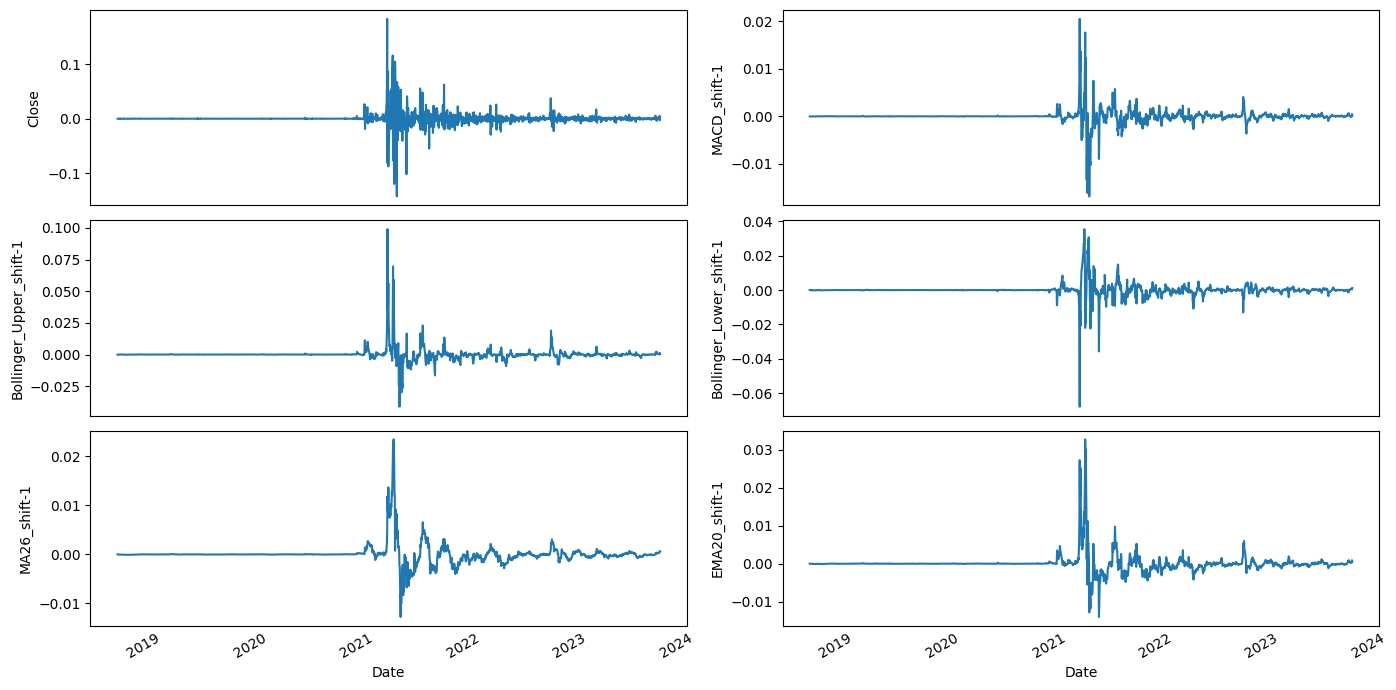

In [61]:
# Plot line charts
df_plot = df_differenced.copy()

ncols = 2
nrows = int(round(df_plot.shape[1] / ncols, 0))

fig, ax = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, figsize=(14, 7))
for i, ax in enumerate(fig.axes):
        sns.lineplot(data = df_plot.iloc[:, i], ax=ax)
        ax.tick_params(axis="x", rotation=30, labelsize=10, length=0)
        ax.xaxis.set_major_locator(mdates.AutoDateLocator())
fig.tight_layout()
plt.show()

Text(0.5, 1.0, 'ACF')

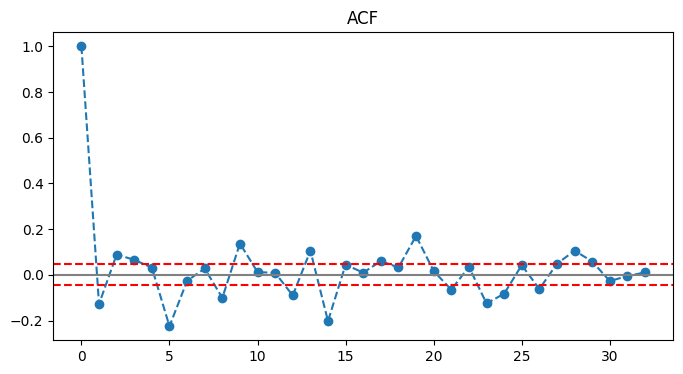

In [62]:
import statsmodels.tsa.stattools as ts
acf_plot = ts.acf(df_differenced['Close'])
# Plot ACF
plt.figure(figsize=(8, 4))
plt.plot(acf_plot, marker='o', linestyle='--')
plt.axhline(y=0, color='gray')
plt.axhline(y=-1.96/np.sqrt(len(df_differenced)), color='red', linestyle='--')
plt.axhline(y=1.96/np.sqrt(len(df_differenced)), color='red', linestyle='--')
plt.title('ACF')

In [63]:
model = VAR(df_differenced)
sorted_order = model.select_order(maxlags=14)
print(sorted_order.summary())


 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0       -73.00      -72.98   1.974e-32      -73.00
1       -151.7      -151.6   1.265e-66      -151.7
2       -203.5      -203.3   4.162e-89      -203.4
3       -202.9      -202.5   7.813e-89      -202.7
4       -202.3      -201.9   1.345e-88      -202.2
5       -202.0      -201.5   1.817e-88      -201.8
6      -262.8*     -262.1* 7.685e-115*     -262.5*
7       -262.4      -261.7  1.048e-114      -262.2
8       -262.2      -261.3  1.334e-114      -261.9
9       -259.8      -258.8  1.495e-113      -259.4
10      -260.9      -259.8  5.115e-114      -260.5
11      -261.3      -260.1  3.169e-114      -260.9
12      -261.0      -259.7  4.297e-114      -260.6
13      -260.9      -259.5  5.052e-114      -260.4
14      -260.8      -259.3  5.426e-114      -260.2
--------------------------------------------------


In [64]:
# Fỉt VAR model
model_fitted = model.fit(6)
print(model_fitted.summary())


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 11, Jun, 2024
Time:                     08:27:25
--------------------------------------------------------------------
No. of Equations:         6.00000    BIC:                   -262.112
Nobs:                     1856.00    HQIC:                  -262.529
Log likelihood:           228274.    FPE:               7.57171e-115
AIC:                     -262.773    Det(Omega_mle):    6.72602e-115
--------------------------------------------------------------------
Results for equation Close
                                coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------------------------
const                              0.000054         0.000259            0.209           0.835
L1.Close                          -0.165024         0.023486           -7.027           0.000
L1.MACD_

In [65]:
# Get the lag order
lag_order = model_fitted.k_ar
print(lag_order)

6


In [66]:
# Input data for forecasting
forecast_input = df_differenced.values[-lag_order:]
forecast_input

array([[ 2.10000000e-04, -1.11026796e-04,  2.04873448e-04,
         7.48726552e-04,  2.49192308e-04,  2.19216699e-04],
       [ 9.35000000e-04, -9.51263733e-05,  2.46412345e-04,
         5.82087655e-04,  2.74461538e-04,  2.18338919e-04],
       [ 2.14500000e-03, -2.37499579e-05,  2.30513962e-04,
         7.42386038e-04,  3.96153846e-04,  2.86592355e-04],
       [ 5.15700000e-03,  1.28966606e-04,  5.05780227e-04,
         6.05219773e-04,  4.69192308e-04,  4.63583559e-04],
       [-2.86300000e-03,  4.87420136e-04,  1.33974696e-03,
         3.86353044e-04,  6.88884615e-04,  9.10575601e-04],
       [ 1.96300000e-03,  1.22933070e-04,  3.02693764e-04,
         1.18180624e-03,  6.00807692e-04,  5.51187449e-04]])

In [67]:
# Forecast test set
fc = model_fitted.forecast(y=forecast_input, steps=len(df_test))
df_forecast = pd.DataFrame(fc, index=df_test.index, columns=df_test.columns + '_1d')
df_forecast

,Close_1d,MACD_shift-1_1d,Bollinger_Upper_shift-1_1d,Bollinger_Lower_shift-1_1d,MA26_shift-1_1d,EMA20_shift-1_1d
Date,,,,,,
2023-11-09,0.000172,0.000221,0.000955,0.000684,0.000657,0.000686
2023-11-10,-0.000111,0.000152,0.001078,0.000413,0.000607,0.000637
2023-11-11,-0.000359,0.000074,0.000984,0.000345,0.000623,0.000566
2023-11-12,0.001069,-0.000007,0.001080,0.000030,0.000580,0.000478
2023-11-13,0.000124,0.000042,0.001002,0.000047,0.000659,0.000534
...,...,...,...,...,...,...
2024-05-28,0.000041,0.000002,0.000047,0.000032,0.000038,0.000039
2024-05-29,0.000041,0.000002,0.000047,0.000033,0.000039,0.000039
2024-05-30,0.000040,0.000002,0.000047,0.000033,0.000039,0.000039


In [68]:
def invert_transformation(df_train, df_forecast, second_diff=False):
    """Revert back the differencing to get the forecast to original scale."""
    df_fc = df_forecast.copy()
    columns = df_train.columns
    for col in columns:        
        # Roll back 2nd Diff
        if second_diff:
            df_fc[str(col)+'_1d'] = (df_train[col].iloc[-1]-df_train[col].iloc[-2]) + df_fc[str(col)+'_2d'].cumsum()
        # Roll back 1st Diff
        df_fc[str(col)+'_forecast'] = df_train[col].iloc[-1] + df_fc[str(col)+'_1d'].cumsum()
    return df_fc

In [69]:
forecast_test_valid = invert_transformation(df_train, df_forecast, second_diff=False)
forecast_test_valid.loc[:, ['Close_forecast']]

,Close_forecast
Date,
2023-11-09,0.075653
2023-11-10,0.075542
2023-11-11,0.075184
2023-11-12,0.076253
2023-11-13,0.076377
...,...
2024-05-28,0.079028
2024-05-29,0.079069
2024-05-30,0.079109


In [70]:
# Forecast next 0 days
n_forecast_days = 90
forecast_input = df_differenced.values[-lag_order:]
forecast = model_fitted.forecast(y=forecast_input, steps=n_forecast_days)
df_forecast = pd.DataFrame(forecast, index=pd.date_range(df_test.index[-1] + dt.timedelta(days=1), periods=n_forecast_days, freq='D'), columns=df_test.columns + '_1d')
df_results = invert_transformation(df_train, df_forecast, second_diff=False)
df_results.loc[:, ['Close_forecast']]
df_results['Close_forecast']

2024-06-02    0.075653
2024-06-03    0.075542
2024-06-04    0.075184
2024-06-05    0.076253
2024-06-06    0.076377
                ...   
2024-08-26    0.074002
2024-08-27    0.074089
2024-08-28    0.074178
2024-08-29    0.074267
2024-08-30    0.074357
Freq: D, Name: Close_forecast, Length: 90, dtype: float64

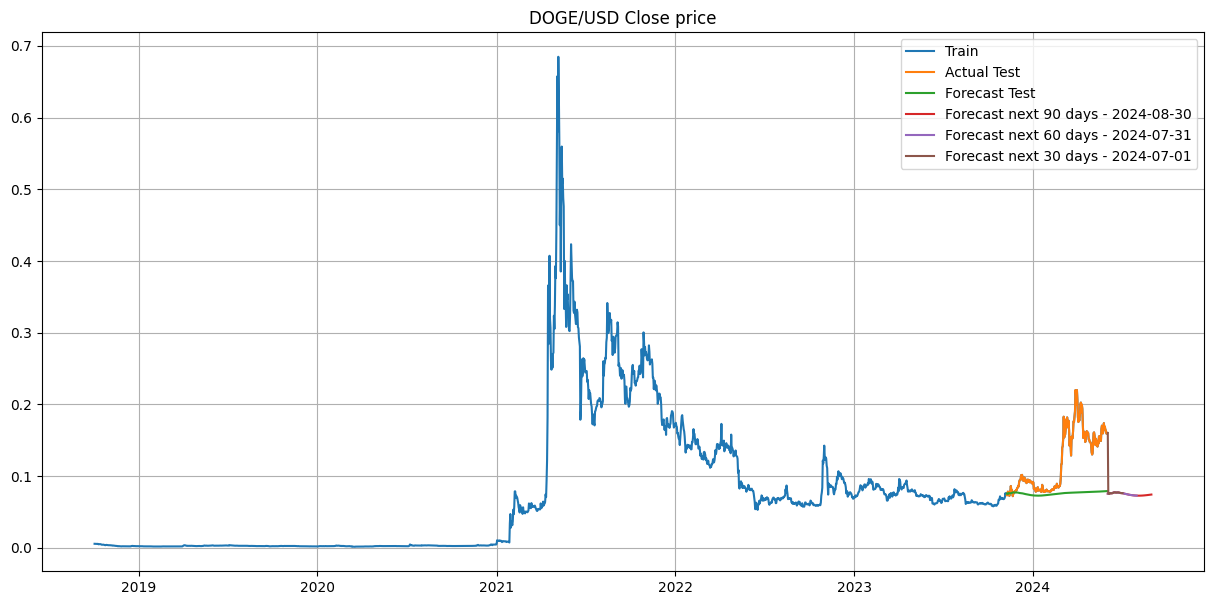

In [71]:
df_forecast_90 = df_results.loc[:, ['Close_forecast']].copy()
df_forecast_90.index = pd.to_datetime(df_forecast_90.index)

df_forecast_60 = df_forecast_90.head(60)
df_forecast_30 = df_forecast_90.head(30)

# Add last value of the original dataset to the forecast 30 days
df_forecast_30.loc[df_filtered.index[-1]] = df_filtered.tail(1).values[0][0]
df_forecast_30 = df_forecast_30.sort_index()

# Label the forecasted data
forecast_30_label = f"Forecast next 30 days - " + df_forecast_30.index[-1].strftime("%Y-%m-%d")
forecast_60_label = f"Forecast next 60 days - " + df_forecast_60.index[-1].strftime("%Y-%m-%d")
forecast_90_label = f"Forecast next 90 days - " + df_forecast_90.index[-1].strftime("%Y-%m-%d")

# Add last day of original data to the forecasted data
df_forecast_30 = pd.concat([df_filtered.tail(1), df_forecast_30])
df_forecast_30.index = pd.date_range(start=df_filtered.index.max(), periods=len(df_forecast_30))

# Plot the overall with connection to forecast
plt.figure(figsize=(15, 7))
plt.plot(df_filtered['Close'], label='Train')
plt.plot(df_test.index, df_test['Close'], label='Actual Test')
plt.plot(forecast_test_valid.index, forecast_test_valid['Close_forecast'], label='Forecast Test')
plt.plot(df_forecast_90.index, df_forecast_90['Close_forecast'], label=forecast_90_label)
plt.plot(df_forecast_60.index, df_forecast_60['Close_forecast'], label=forecast_60_label)
plt.plot(df_forecast_30.index, df_forecast_30['Close_forecast'], label=forecast_30_label)
plt.title('DOGE/USD Close price')
plt.grid()
plt.legend()
plt.show()

In [72]:
# Model Evaluation
def calculate_metrics(y_true, y_pred):
    rmse = np.sqrt(np.mean((y_true - y_pred)**2))
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    smape = np.mean((np.abs(y_pred - y_true) * 200 / (np.abs(y_pred) + np.abs(y_true))))
    return rmse, mape, smape

# Calculate metrics
rmse, mape, smape = calculate_metrics(df_test['Close'], forecast_test_valid['Close_forecast'])
print(f"RMSE: {rmse:.4f}")
print(f"MAPE: {mape:.4f}")
print(f"SMAPE: {smape:.4f}")

RMSE: 0.0600
MAPE: 29.8720
SMAPE: 38.8171
